In [1]:
import json
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from sklearn.neighbors import KernelDensity


In [2]:
def read_eye_tracking_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    eye_tracking_data = []

    for line in lines:
        data = json.loads(line)
        eye_tracking_data.append(data)

    return eye_tracking_data

def parse_data(eye_tracking_data):
    # Grouping data by 'gidx' and organizing it 
    grouped_data = {}

    for data in eye_tracking_data:
        gidx = data.get('gidx')

        if gidx is not None:
            if gidx not in grouped_data:
                grouped_data[gidx] = {
                    'ts' :None,
                    'pcl':None,
                    'pcr':None,
                    'pdl': None,
                    'pdr': None,
                    'gdl': None,
                    'gdr': None,
                    'gp':None,
                    'gp3': None
                }

            # Extracting pupil diameter for left and right eyes
            ts_data = data.get('ts',None)
            grouped_data[gidx]['ts'] = ts_data
            pc_data = data.get('pc',None)
            pd_data = data.get('pd', None)
            gd_data = data.get('gd',None)
            gp_data = data.get('gp',None)
            gp3_data = data.get('gp3',None)
            eye = data.get('eye',None)

            if pc_data is not None:
                if eye =='left':
                    grouped_data[gidx]['pcl'] = pc_data
                elif eye =='right':
                    grouped_data[gidx]['pcr'] = pc_data 

            if pd_data is not None:
                if eye =='left':
                    grouped_data[gidx]['pdl'] = pd_data
                elif eye =='right':
                    grouped_data[gidx]['pdr'] = pd_data 

            if gd_data is not None:
                if eye =='left':
                    grouped_data[gidx]['gdl'] = gd_data
                elif eye =='right':
                    grouped_data[gidx]['gdr'] = gd_data
            if gp_data is not None:
                grouped_data[gidx]['gp'] = gp_data
            if gp3_data is not None:
                grouped_data[gidx]['gp3'] = gp3_data
    return grouped_data

def print_data(grouped_data):
    for gidx, data_dict in grouped_data.items():
        print(f"Group with gidx={gidx}:")
        print(f"  pcl: {data_dict['pcl']}")
        print(f"  pcr: {data_dict['pcr']}")
        print(f"  pdl: {data_dict['pdl']}")
        print(f"  pdr: {data_dict['pdr']}")
        print(f"  gdl: {data_dict['gdl']}")
        print(f"  gdl: {data_dict['gdl']}")
        print(f"  gp: {data_dict['gp']}")
        print(f"  gp3: {data_dict['gp3']}")
        print("\n")

In [3]:
file_path = 'subject4/livedata.json'
eye_tracking_data = read_eye_tracking_data(file_path)
grouped_data = parse_data(eye_tracking_data)
# print_data(grouped_data)

FileNotFoundError: [Errno 2] No such file or directory: 'livedata.json'

In [4]:
with open('fixation.csv', 'w', newline='') as csvfile:
    # Define the CSV writer
    csv_writer = csv.writer(csvfile)

    # Write the header
    csv_writer.writerow(['start_timestamp', 'gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z'])

    # Write the data
    for gidx, data in grouped_data.items():
        time_stamp = data['ts']/(1e3)
        gp3_x = data['gp3'][0]
        gp3_y = data['gp3'][1]
        gp3_z = data['gp3'][2]

        csv_writer.writerow([time_stamp, gp3_x, gp3_y, gp3_z])

print("CSV file created successfully.")

NameError: name 'grouped_data' is not defined

In [5]:
lambda0 = 2
#reading dataset

dataGaze = pd.read_csv('fixation.csv')

# #properties from dataset
attribs = dataGaze.columns
dataGaze.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   start_timestamp  0 non-null      object
 1   gaze_point_3d_x  0 non-null      object
 2   gaze_point_3d_y  0 non-null      object
 3   gaze_point_3d_z  0 non-null      object
dtypes: object(4)
memory usage: 0.0+ bytes


In [6]:

#3 - Conversion To Spherical Coordinates
#In order to calculate the gaze velocity in degrees per second,
#we will have to convert the data from its cartesian coordinate system to a spherical coordinate system.
#Afterwards we plot the spherical coordinates over time and in space.
def cart_to_spherical(dataGaze, apply_rad2deg=False):
    x = dataGaze.gaze_point_3d_x
    y = dataGaze.gaze_point_3d_y
    z = dataGaze.gaze_point_3d_z
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(y / r)  # for elevation angle defined from Z-axis down
    psi = np.arctan2(z, x)

    if apply_rad2deg:
        theta = np.rad2deg(theta)
        psi = np.rad2deg(psi)

    return r, theta, psi

def get_velocity(t, x, y):
     # Check for NaN and Inf values
    if np.any(np.isnan(t)) or np.any(np.isnan(x)) or np.any(np.isnan(y)):
        # Handle or skip this case
        return np.zeros_like(t[:-1]), np.zeros_like(t[:-1])  # Return zeros for velocity

    if np.any(np.isinf(t)) or np.any(np.isinf(x)) or np.any(np.isinf(y)):
        # Handle or skip this case
        return np.zeros_like(t[:-1]), np.zeros_like(t[:-1])  # Return zeros for velocity
 
    dt = np.diff(t)
    dx = np.diff(x)
    dy = np.diff(y)
        # Handle division by zero
    nonzero_dt = dt[dt != 0]  # Exclude zero differences to avoid division by zero
    dtheta_dt = np.divide(dx, nonzero_dt)
    dpsi_dt = np.divide(dy, nonzero_dt)
    print(len(dtheta_dt),len(nonzero_dt),len(dpsi_dt))
    return dtheta_dt,dpsi_dt

def sphere_pos_over_time(ts, data, unit="radians"):
    for key, values in data.items():
        sns.lineplot(x=ts, y=values, label=key)

    plt.xlabel("time [sec]")
    plt.ylabel(unit)
    plt.legend()

def sphere_pos(r, theta, psi, unit="radians"):
    print(r.min(), r.max())
    norm = colors.LogNorm(vmin=r.min()+1e-12, vmax=r.max())
    points = plt.scatter(
        theta,
        psi,
        c=r,
        alpha=0.5,
        cmap="jet",
        norm=norm,

    )
    cbar = plt.colorbar(points)
    cbar.ax.set_ylabel("distance [mm]", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    plt.xlabel(f"theta [{unit[:3]}]")
    plt.ylabel(f"psi [{unit[:3]}]")


In [7]:
import datetime

timestamp = 925772114
dt_object = datetime.datetime.fromtimestamp(timestamp)
print(dt_object)

1999-05-04 04:25:14


In [8]:
r, theta, psi = cart_to_spherical(dataGaze, apply_rad2deg=True)

In [9]:

#####################    plots    #####################
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sphere_pos_over_time(
    dataGaze.start_timestamp,
    data={"psi": psi,"theta":theta},
    unit="degrees"
)

plt.subplot(2, 1, 2)
sphere_pos(r, theta, psi, unit="degrees")
for i in range(len(idx) - 1):
    if idx[i] == 1:
        plt.plot([theta[i], theta[i+1]], [psi[i], psi[i+1]], 'r', LineWidth = 3)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


nan nan


ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x0000024EA8279820> (for post_execute):


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 864x864 with 3 Axes>

In [41]:
# Calculating Gaze Velocity
dtheta_dt, dpsi_dt = get_velocity(dataGaze.start_timestamp, theta, psi)

deg_per_sec = np.sqrt(dtheta_dt**2 + dpsi_dt**2)
print(deg_per_sec)
print(dtheta_dt)
print(dpsi_dt)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [42]:
#5 - Visualizing Gaze Velocity
#Here we show how to visualize gaze velocity over time as well as the distribution of different velocities.

time = (dataGaze.start_timestamp[:-1] - dataGaze.start_timestamp.iloc[0])
#sigma_theta = np.mean(dtheta_dt**2) - np.mean(dtheta_dt)**2
#sigma_psi   = np.mean(dpsi_dt**2  ) - np.mean(dpsi_dt)**2

sigma_theta = np.sqrt(np.mean((dtheta_dt - np.mean(dtheta_dt))**2))
sigma_psi   = np.sqrt(np.mean((dpsi_dt   - np.mean(dpsi_dt  ))**2))

eta_theta = lambda0*sigma_theta
eta_psi  = lambda0*sigma_psi

tk = (dtheta_dt/eta_theta)**2 + (dpsi_dt/eta_psi)**2
idx = tk > 1

### number of saccades
nSaccade = np.sum(idx)
print('Number of saccades is ', nSaccade)

# getting density distribution vs. amplitude and fixation duration
amplitude = np.sqrt(theta**2 + psi**2)

### mean saccade speed
meanSpeed = 0
for i in range(len(idx) - 1):
    if idx[i] == 1:
        meanSpeed = meanSpeed + amplitude[i]

meanSpeed = meanSpeed/nSaccade
print('Mean saccade speed is ', meanSpeed, '(deg/s)')

Number of saccades is  0
Mean saccade speed is  nan (deg/s)


<ipython-input-42-1c89d82f7d30>:14: RuntimeWarning: invalid value encountered in true_divide
  tk = (dtheta_dt/eta_theta)**2 + (dpsi_dt/eta_psi)**2
<ipython-input-42-1c89d82f7d30>:30: RuntimeWarning: invalid value encountered in long_scalars
  meanSpeed = meanSpeed/nSaccade


ValueError: array must not contain infs or NaNs

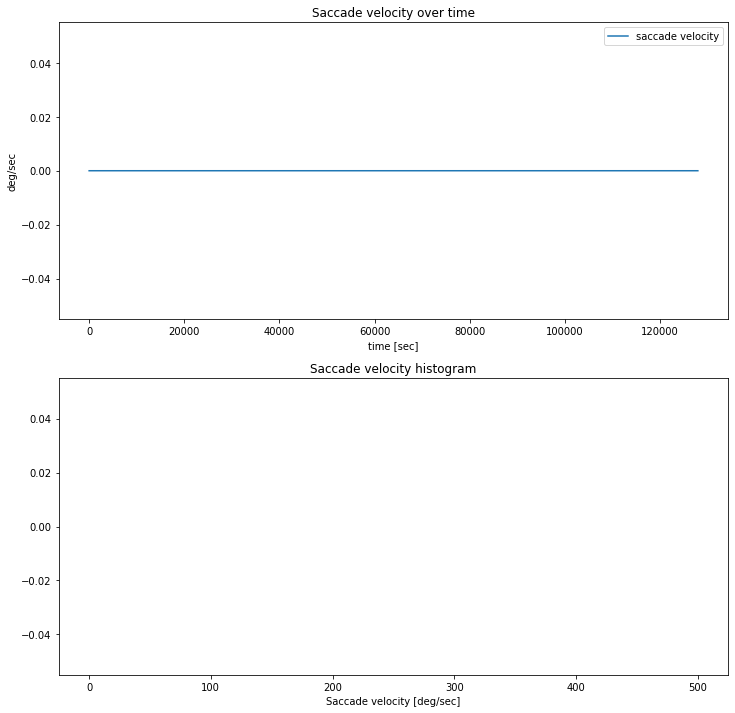

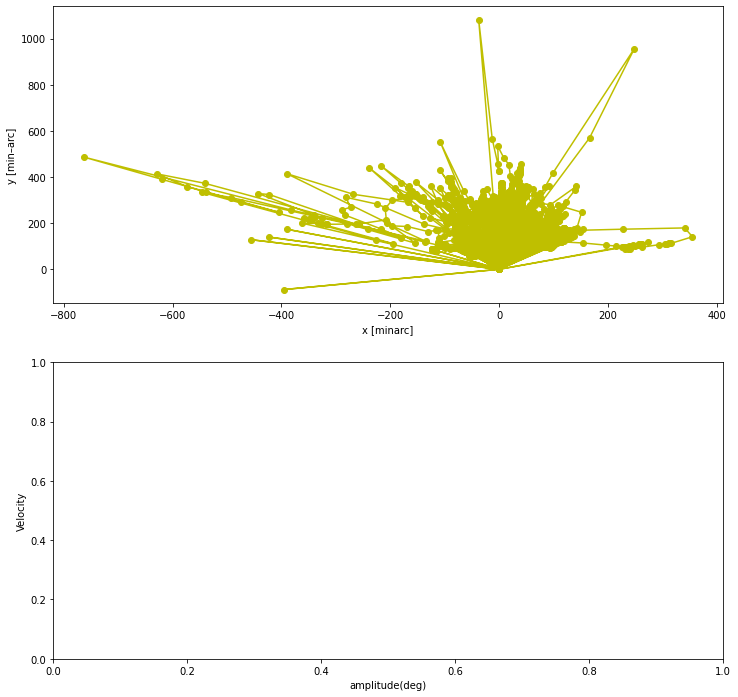

<Figure size 864x864 with 0 Axes>

In [48]:

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sphere_pos_over_time(time, {"saccade velocity": deg_per_sec}, unit="deg/sec")
plt.title("Saccade velocity over time")

plt.subplot(2, 1, 2)
plt.hist(deg_per_sec, bins=np.logspace(-1, np.log10(500), 50))
plt.title("Saccade velocity histogram")
plt.xlabel("Saccade velocity [deg/sec]")


plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(dataGaze.gaze_point_3d_x, dataGaze.gaze_point_3d_y, 'y-o')
for i in range(len(idx) - 1):
    if idx[i] == 1:
        plt.plot([dataGaze.gaze_point_3d_x[i], dataGaze.gaze_point_3d_x[i+1]], [dataGaze.gaze_point_3d_y[i], dataGaze.gaze_point_3d_y[i+1]], 'r-+', LineWidth = 3)
plt.xlabel('x [minarc]')
plt.ylabel('y [min–arc]')

plt.subplot(2, 1, 2)
amp_cums  = np.cumsum(amplitude)
velo_deg  = np.sqrt(dtheta_dt**2 + dpsi_dt**2)
for i in range(len(idx) - 1):
    if idx[i] == 1:
        plt.loglog(np.cumsum(amp_cums[i]), velo_deg[i], 'ko')
plt.xlabel('amplitude(deg)')
plt.ylabel('Velocity')

plt.figure(figsize = (12, 12))
kde = stats.gaussian_kde(np.array(amplitude))
Z   = kde(amplitude)
plt.plot(Z)
plt.title('Density vs. amplitude')
plt.xlabel('amplitude(deg)')
plt.ylabel('Density')

In [16]:
import numpy as np

def detect_saccades(gaze_data, timestamps, threshold_degrees=1.0, min_duration_ms=20000):
    """
    Detect saccades in 3D gaze data.

    Parameters:
    - gaze_data: 2D numpy array representing 3D gaze points (each row is [x, y, z]).
    - timestamps: 1D numpy array representing corresponding timestamps.
    - threshold_degrees: Threshold for detecting saccades (default is 1.0 degree).
    - min_duration_ms: Minimum duration for a saccade (default is 20 milliseconds).

    Returns:
    - List of saccade start and end indices.
    """

    # Calculate gaze direction vectors
    gaze_vectors = np.diff(gaze_data, axis=0)

    # Calculate angular speed (magnitude of the change in direction)
    angular_speed = np.linalg.norm(gaze_vectors, axis=1)

    # Convert angular speed to degrees (assuming linear relationship)
    angular_speed_degrees = np.degrees(angular_speed)

    # Identify saccade candidates based on threshold
    saccade_candidates = np.where(angular_speed_degrees > threshold_degrees)[0]

    # Filter candidates based on duration
    saccades = []
    current_saccade_start = None

    for idx in saccade_candidates:
        if current_saccade_start is None:
            current_saccade_start = idx
        elif timestamps[idx] - timestamps[current_saccade_start] > min_duration_ms:
            saccades.append((current_saccade_start, idx))
            current_saccade_start = None

    return saccades

# Example usage
# Assuming gaze_data is a 2D numpy array with columns [x, y, z]
# and timestamps is a 1D numpy array with corresponding timestamps
gaze_data =[]
timestamps =[]
for gidx, data in grouped_data.items():
    gaze_data.append(grouped_data[gidx]['gp3'])
    timestamps.append(grouped_data[gidx]['ts'])
saccades = detect_saccades(gaze_data, timestamps)
print("Saccades detected:", saccades)


Saccades detected: [(0, 2), (3, 6), (7, 10), (11, 14), (15, 17), (18, 20), (21, 24), (25, 28), (29, 32), (33, 36), (37, 41), (42, 45), (46, 49), (50, 53), (54, 57), (58, 61), (62, 65), (67, 70), (71, 74), (75, 78), (79, 82), (83, 86), (87, 90), (91, 93), (94, 97), (98, 101), (102, 105), (106, 108), (109, 112), (113, 116), (117, 120), (121, 124), (125, 128), (129, 132), (133, 135), (136, 139), (140, 143), (144, 146), (147, 150), (151, 154), (155, 157), (158, 161), (162, 165), (166, 168), (169, 172), (173, 176), (177, 180), (181, 184), (185, 188), (189, 192), (193, 195), (196, 199), (200, 203), (204, 207), (208, 210), (211, 214), (215, 218), (219, 221), (222, 225), (226, 229), (230, 233), (234, 237), (238, 241), (242, 245), (246, 248), (249, 252), (253, 256), (257, 259), (260, 263), (264, 267), (268, 271), (272, 275), (276, 279), (280, 283), (284, 287), (288, 291), (292, 295), (296, 299), (300, 303), (304, 307), (308, 310), (311, 316), (317, 321), (322, 325), (326, 329), (330, 333), (334

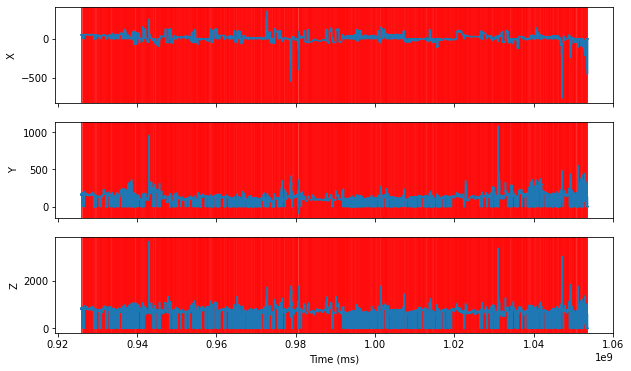

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaze_with_saccades(gaze_data, timestamps, saccades):
    """
    Plot 3D gaze data with saccades over time.

    Parameters:
    - gaze_data: 2D numpy array representing 3D gaze points (each row is [x, y, z]).
    - timestamps: 1D numpy array representing corresponding timestamps.
    - saccades: List of saccade start and end indices.
    """

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
    ax[0].plot(timestamps, gaze_data[:, 0], label='X')
    ax[1].plot(timestamps, gaze_data[:, 1], label='Y')
    ax[2].plot(timestamps, gaze_data[:, 2], label='Z')

    # Mark saccades on the plot
    for saccade_start, saccade_end in saccades:
        start_time, end_time = timestamps[saccade_start], timestamps[saccade_end]
        for a in ax:
            a.axvspan(start_time, end_time, color='red', alpha=0.3)

    ax[0].set_ylabel('X')
    ax[1].set_ylabel('Y')
    ax[2].set_ylabel('Z')
    ax[2].set_xlabel('Time (ms)')
    # ax[2].set_xlim(0,0000000)

    plt.show()

# Convert gaze_data to a NumPy array if it's not already
gaze_data = np.array(gaze_data)

# Example usage
# Assuming timestamps is a 1D numpy array with corresponding timestamps
# and saccades is a list of saccade start and end indices

plot_gaze_with_saccades(gaze_data, timestamps, saccades)


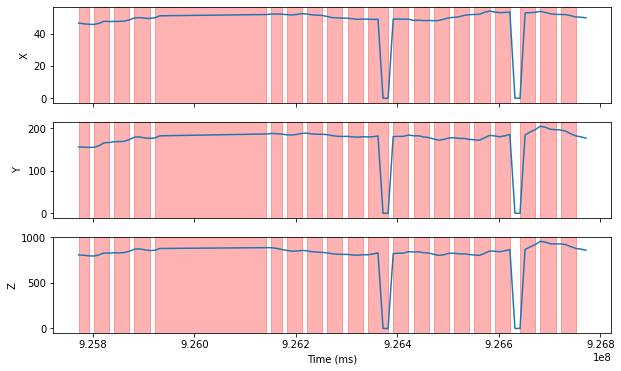

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaze_with_saccades(gaze_data, timestamps, saccades, plot_duration=1e6):
    """
    Plot 3D gaze data with saccades over a specified duration.

    Parameters:
    - gaze_data: 2D numpy array representing 3D gaze points (each row is [x, y, z]).
    - timestamps: 1D numpy array representing corresponding timestamps.
    - saccades: List of saccade start and end indices.
    - plot_duration: Duration (in milliseconds) to plot.

    Note: If plot_duration is set to None, the entire data will be plotted.
    """

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))

    # Find the index corresponding to the end of the specified duration
    end_index = np.searchsorted(timestamps, timestamps[0] + plot_duration)

    ax[0].plot(timestamps[:end_index], gaze_data[:end_index, 0], label='X')
    ax[1].plot(timestamps[:end_index], gaze_data[:end_index, 1], label='Y')
    ax[2].plot(timestamps[:end_index], gaze_data[:end_index, 2], label='Z')

    # Mark saccades on the plot
    for saccade_start, saccade_end in saccades:
        if saccade_start < end_index and saccade_end < end_index:
            start_time, end_time = timestamps[saccade_start], timestamps[saccade_end]
            for a in ax:
                a.axvspan(start_time, end_time, color='red', alpha=0.3)

    ax[0].set_ylabel('X')
    ax[1].set_ylabel('Y')
    ax[2].set_ylabel('Z')
    ax[2].set_xlabel('Time (ms)')

    plt.show()

# Convert gaze_data to a NumPy array if it's not already
gaze_data = np.array(gaze_data)

# Example usage
# Assuming timestamps is a 1D numpy array with corresponding timestamps
# and saccades is a list of saccade start and end indices

plot_gaze_with_saccades(gaze_data, timestamps, saccades, plot_duration=1e6)
